# Basic tests for the augmentation

In [1]:
import utils as ut
import numpy as np
import matplotlib.pyplot as plt

The `SinusGenerator` is a utility class to generate a basic signal with or without noise

In [2]:
sgen = ut.SinusGenerator(4, 20, 0, 0.2)

pure_data = sgen.generate_basic()
noise_data, _, _ = sgen.generate_noise()

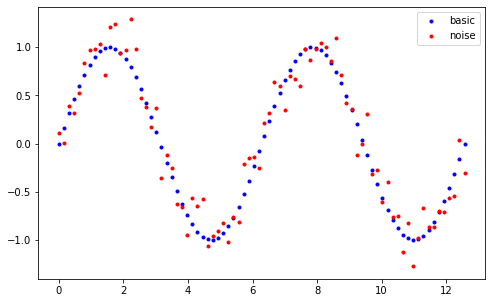

In [3]:
plt.figure(figsize=(8,5))

plt.plot(pure_data[:,0], pure_data[:,1], 'b.', label='basic')
plt.plot(noise_data[:,0], noise_data[:,1], 'r.', label='noise')

plt.legend(loc='best')
plt.show()

## Augmentation

With the basic signal we have a signal augmentation utility

In [4]:
augment = ut.AugmentTSSignal(noise_data)

We can see that the basic object of augment does nothing

In [5]:
def print_augmented_signal(d, label, missing_label = None, org_d_color = 'b.', missing_d_color = 'r.'):
    oc, mc = org_d_color, missing_d_color
    ml = missing_label
    plt.figure(figsize=(8,5))
    if d.shape[1] == 3:
        org_d = d[d[:,-1]==0]
        new_d = d[d[:,-1]==1]
        plt.plot(org_d[:,0], org_d[:,1], oc, label=label)
        plt.plot(new_d[:,0], new_d[:,1], mc, label=label + ' missing values' if ml is None else ml)
    else:
        plt.plot(d[:,0], d[:,1], oc, label=label)
    plt.legend(loc='best')
    plt.show()

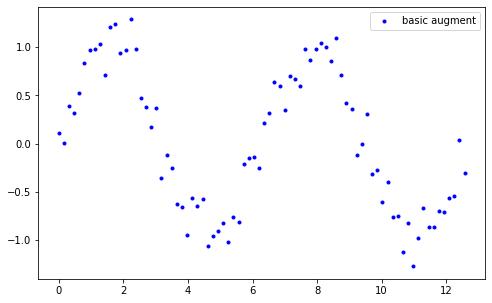

In [6]:
print_augmented_signal(augment.data, 'basic augment')

We can now augment the timeseries with a set of chained calls. F.e. `augment.expand(20,100).downsample(2).sub_moise(0.0, 0.2)`

Let's investigate each call on it's own:

### Expanding TS to a maximum frequency representaton

For expanding the signal to a new sampling frequencey. The augmentor only expands the number of entries in the signal and adds a colum to mark if the value is a missing value or original data. However, it does not know onything about the time index a specific signal uses, so we need to expand this.

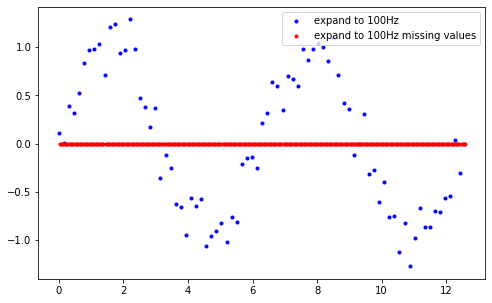

In [7]:
def correct_time(aug):
    d = np.copy(aug.data)
    d[:,0] = sgen.linespace(d.shape[0])
    return d

expanded = augment.expand(20, 100).apply_callback(correct_time)

print_augmented_signal(expanded.data, 'expand to 100Hz')

### "Downsampling" aka Removing Data Points

For "downsampling" we currently just set every nth real data points value to zero and add it to the missing values. This means that if a 20Hz signal is expanded to 100Hz we still downsample from the 20Hz signal

In [8]:
downsample_original = augment.downsample(2, is_all_data=True) # remove every second point
downsample_expaneded = expanded.downsample(2)

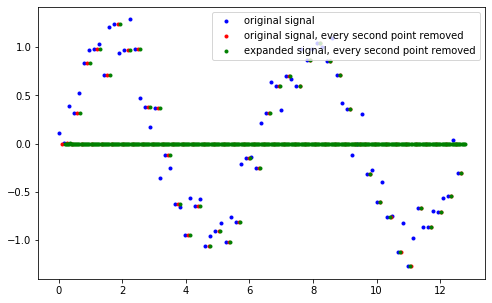

In [9]:
od = augment.data
osd = downsample_original.data
esd = downsample_expaneded.data

plt.figure(figsize=(8,5))

plt.plot(od[:,0], od[:,1], 'b.', label='original signal')
plt.plot(osd[:,0]+0.1, osd[:,1], 'r.', label='original signal, every second point removed')
plt.plot(esd[:,0]+0.2, esd[:,1], 'g.', label='expanded signal, every second point removed')

plt.legend(loc='best')
plt.show()

Another way to show the downsampling is to plott the signals each individual in a plot and compare the two pictures

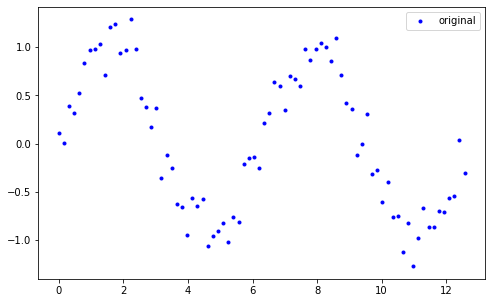

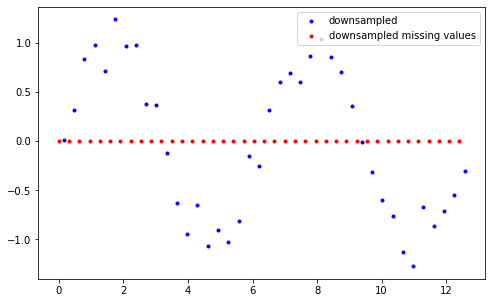

In [10]:
print_augmented_signal(augment.data, 'original')
down_data = downsample_original.data
print_augmented_signal(down_data, 'downsampled')


### Adding Noise

Another possible augmentation is to jitter the values a bit by adding gaussian noise. So since they are drawn from a 
gaussian adding or subtracting them should not differ. For now I have implemented both interfaces anyway

data with only two columns is assumed to have no missing value field, just return the whole index
data with only two columns is assumed to have no missing value field, just return the whole index


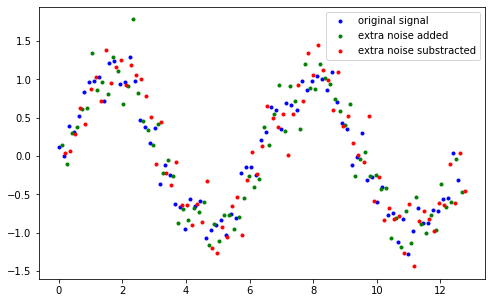

In [11]:
od = augment.data
add_d = augment.add_noise(0.0, 0.2).data
sub_d = augment.sub_moise(0.0, 0.2).data

plt.figure(figsize=(8,5))

plt.plot(od[:,0], od[:,1], 'b.', label='original signal')
plt.plot(add_d[:,0]+0.1, add_d[:,1], 'g.', label='extra noise added')
plt.plot(sub_d[:,0]+0.2, sub_d[:,1], 'r.', label='extra noise substracted')

plt.legend(loc='best')
plt.show()

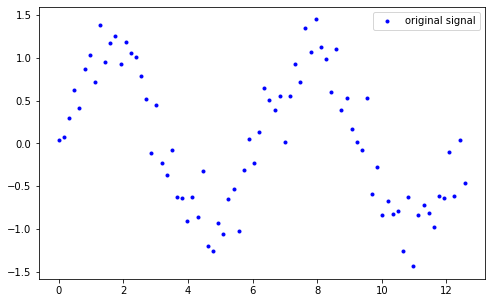

In [12]:
plt.figure(figsize=(8,5))

plt.plot(sub_d[:,0], sub_d[:,1], 'b.', label='original signal')

plt.legend(loc='best')
plt.show()

### Removal of block / ablations

The next augmentation we have is setting some complete blocks of the signal as missing data. This helps f.e. to cope
with faulty sensors

### Removal of block / ablations

The next augmentation we have is setting some complete blocks of the signal as missing data. This helps f.e. to cope
with faulty sensors

data with only two columns is assumed to have no missing value field, just return the whole index


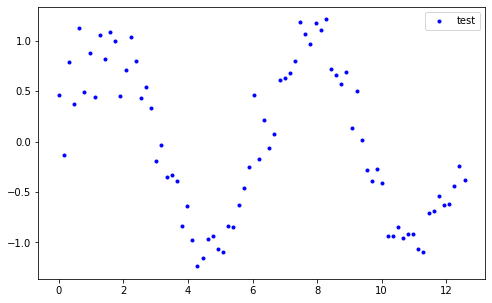

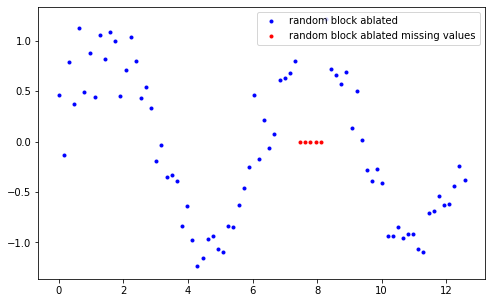

In [12]:
n = len(augment.data)
n_min = n/20
n_max = n/10
od = augment.data
block_offset, block_length = augment.random_block(n_min, n_max)
block_removed = augment.rem_block(block_offset, block_length)
rbd = block_removed.data

assert len(od) == len(rbd)
missing_rdb = rbd[rbd[:,-1]==1]
assert len(missing_rdb) == block_length

print_augmented_signal(od, 'test')
print_augmented_signal(rbd, 'random block ablated')



